T12: 1hr @ 0.5kHz vs T13: 0.5hr @ 1kHz. Both 0.75 Er and 1.5 Er targets.

In [2]:
import numpy as np
import glob as gb
import os
import matplotlib.pyplot as plt
import photonics.fluorescence as fl

%matplotlib notebook

In [3]:
save = False

In [4]:
def getfilename(file):
    # Get name from file
    fname = os.path.basename(file)
    fname = os.path.splitext(fname)[0]
    return fname

def getsampleid(file):
    name = getfilename(file)
    sampleno = name.split('_')[0]
    return sampleno

# Spectrum

In [5]:
files = gb.glob('./Spectrum/*.txt')
files = sorted(files, key=lambda x: getsampleid(x)[2:])

# Select only T12 and T13
files = [x for x in files if '12' in x or '13' in x]
files

['./Spectrum\\T12.txt', './Spectrum\\T13.txt']

<IPython.core.display.Javascript object>


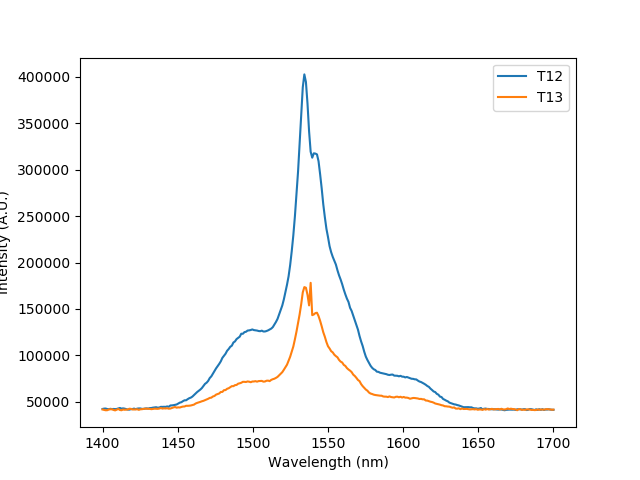

In [6]:
# Unnormalised
fig = plt.figure()
ax = fig.add_subplot(111)

imax = []
for f in files:
    # Load data
    data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=22, usecols=(0,1))
    x = data[:,0]
    y = data[:,1]
    imax.append(max(y))

    ax.plot(x, y, label=getsampleid(f))

    plt.legend()
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (A.U.)')
    
if save:
    plt.savefig('./spectrum_raw')

In [7]:
print('Ratio of maximum intensities: {:.3f}'.format(imax[0]/imax[1]))

Ratio of maximum intensities: 2.261


<IPython.core.display.Javascript object>


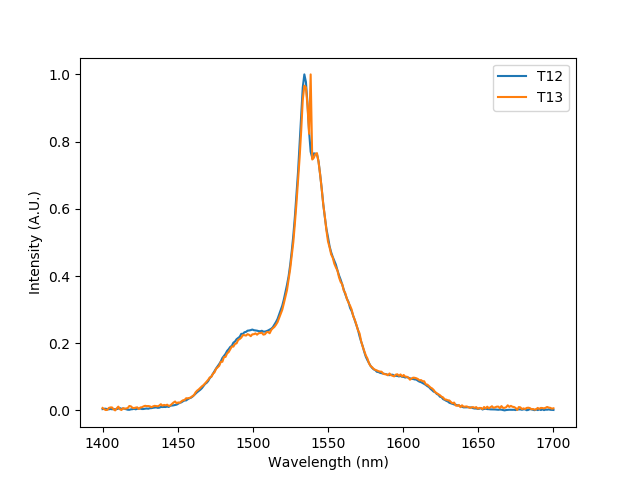

In [9]:
# Normalised
fig = plt.figure()
ax = fig.add_subplot(111)

for f in files:
    # Load data
    data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=22, usecols=(0,1))
    x = data[:,0]
    y = data[:,1]

    # Normalise
    y = fl.normalise(y)

    ax.plot(x, y, label=getsampleid(f))

    plt.legend()
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (A.U.)')
    
if save:
    plt.savefig('./spectrum_normalised')

# Lifetime

In [17]:
# select files to analyse
files = gb.glob('./Lifetime/secondAttempt/*.txt')

# Select only T12 and T13
files = [x for x in files if '12' in x or '13' in x]

In [21]:
# Select the required pump
pump = 1
lamp_delay = 0.1

## Together in air

<IPython.core.display.Javascript object>


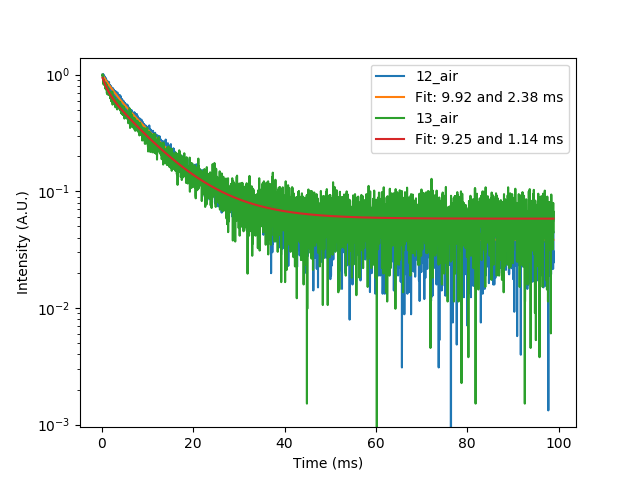

In [22]:
# Plot data
fig = plt.figure()
ax = fig.add_subplot(111)

##############
# T12
sample = '12_air'
f =  [x for x in files if sample in x]
data = np.genfromtxt(fname=f[0], delimiter=',', dtype=float, skip_header=10, usecols=(0,1))
x = data[:,0]/1E6  # Convert time from us to ms
y = data[:,1]

x = fl.shift_time(x, length=pump+lamp_delay)
x, y = fl.reject_time(x, y, reject_start=0.1, reject_end=0)
y = fl.normalise(y, ref='start')

# Plot raw data
ax.plot(x, y, label=sample)

# Fit and plot
popt = fl.fit_decay2(x, y)
ax.plot(x, fl.decay_fn2(x, *popt), label='Fit: {:.2f} and {:.2f} ms'.format(popt[1], popt[3]))

############
# T13
sample = '13_air'
f =  [x for x in files if sample in x]

data = np.genfromtxt(fname=f[0], delimiter=',', dtype=float, skip_header=10, usecols=(0,1))
x = data[:,0]/1E6  # Convert time from us to ms
y = data[:,1]

x = fl.shift_time(x, length=pump+lamp_delay)
x, y = fl.reject_time(x, y, reject_start=0.1, reject_end=0)
y = fl.normalise(y, ref='start')

# Plot raw data
ax.plot(x, y, label=sample)

# Fit and plot
popt = fl.fit_decay2(x, y)
ax.plot(x, fl.decay_fn2(x, *popt), label='Fit: {:.2f} and {:.2f} ms'.format(popt[1], popt[3]))

ax.set_yscale('log')
# plt.xlim(0, 100)
# plt.ylim(0.1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Intensity (A.U.)')
plt.legend()

if save:
    plt.savefig('./lifetime_both')

<IPython.core.display.Javascript object>


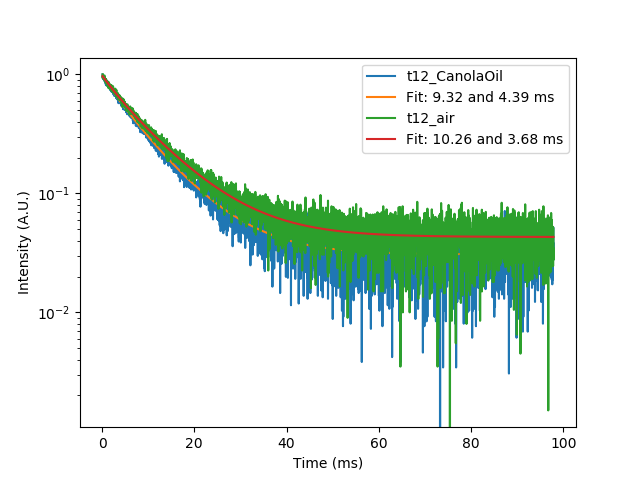

9.32342128087
10.2613218456


In [20]:
sample = '12' # '12' or '13', optional '_air'

fig = plt.figure()
ax = fig.add_subplot(111)

for f in [x for x in files if sample in x]:

    data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=10, usecols=(0,1))
    x = data[:,0]/1E6  # Convert time from us to ms
    y = data[:,1]

    x = fl.shift_time(x, length=pump+lamp_delay)
    x, y = fl.reject_time(x, y, reject_start=0.1, reject_end=0)
    y = fl.normalise(y, ref='start')
    
    # Plot raw data
    ax.plot(x, y, label=getfilename(f))

    # Fit and plot
    popt = fl.fit_decay2(x, y)
    ax.plot(x, fl.decay_fn2(x, *popt), label='Fit: {:.2f} and {:.2f} ms'.format(popt[1], popt[3]))
    print(popt[1])

ax.set_yscale('log')
plt.xlabel('Time (ms)')
plt.ylabel('Intensity (A.U.)')
plt.legend()

if save:
    plt.savefig('./lifetime_' + sample)

# Prism Coupler Data

| Sample | n      | d      |
|--------|--------|--------|
|   T12  | 1.4914 | 0.5659 |
| T13    | 1.6235 | 0.3379 |

# Purcell Factor

Comparing air and covered in cassia oil. Note only T13 supports waveguiding.

T12 - 1.096184

T13 - 1.152419 (WG) or 1.268119 (no WG)

In [54]:
from IPython.display import IFrame
IFrame("./purcell_factor_indivd_T12.png", width=900, height=500)

In [55]:
IFrame("./purcell_factor_indivd_T13.png", width=900, height=500)

# Quantum Efficiency

In [20]:
# T12
tau1 = 10.1449369947
tau2 = 9.15625846878
beta = 1.096184  # Theoretical SE ratio (Gamma_rad: 1/2)

# T13
# tau_1 = 9.3843239181
# tau_2 = 8.34754290672
# beta = 1.152419  # 1.152419 (WG) or 1.268119 (no WG)

matrix = np.array([[1, 1], [beta, 1]])

# Invert matrix
inv = np.linalg.inv(matrix)

rhs = 1e3*np.array([[1/tau1], [1/tau2]])

# Solve radiative and non-radiative decay rates
lhs = inv @ rhs
rad = lhs[0][0]
nrad = lhs[1][0]

print('Radiative decay rate    : {:.2f} /s'.format(rad))
print('Non-radiative decay rate: {:.2f} /s \n'.format(nrad))

print('Radiative lifetime      : {:.3f} ms'.format(1e3/rad))
print('Non-radiative lifetime  : {:.3f} ms'.format(1e3/nrad))

q = rad / (rad + nrad)
print('Quantum Efficiency is {:.3%}'.format(q))

Radiative decay rate    : 110.66 /s
Non-radiative decay rate: -12.09 /s 

Radiative lifetime      : 9.037 ms
Non-radiative lifetime  : -82.732 ms
Quantum Efficiency is 112.262%


In [18]:
tau1 / tau2

1.1074558566301203